In [190]:
import tensorflow as tf
from tensorflow import keras

In [191]:
from sklearn.model_selection import train_test_split

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=5000, random_state=42)

In [192]:
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

In [193]:
from tensorflow.train import Feature, Features, Example, BytesList, Int64List

def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label]))
            }
        )
    )

In [194]:
for image, label in valid_set.take(1):
    print(create_example(image, label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\002\004\000\000\223}jq\033\000\001\000\000\000\000\000\000\000\000\000\000\000\000\001\001\000\000\000\003\000\033\306;\000\000\020|(\000\002\001\000\000\000\000\000\000\000\000\000\000\000\000\001\002\000\002\000\2552\000\000\000\000\000\211\000\000\000\001\001\000\000\001\000\000\000\000\000\000\000\000\001\000\000\003\214\000\000\000\000\n\000e-\000\004\000\000\001\001\000\000\000\000\000\000\000\001\000\000\004\000\035\221\000\000\002\002\003\000+e\000\007\000\000\000\001\000\000\000\000\000\000\000\000\000\000\002\000i\213\000\000\000\000\001\000\007\233\000\000\000\000\000\000\000\

In [195]:
from contextlib import ExitStack

def to_tfrecords(name, dataset, n_shards=5):
    paths = ["{}.tfrecord-{:02d}-of-{:02d}".format(name, index, n_shards) for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path)) for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return paths

In [196]:
train_filepaths = to_tfrecords("./tfrecords/my_fashion_mnist.train", train_set)
valid_filepaths = to_tfrecords("./tfrecords/my_fashion_mnist.valid", valid_set)
test_filepaths = to_tfrecords("./tfrecords/my_fashion_mnist.test", test_set)

In [197]:
def preprocessing(tfrecord):
    feature_descriptions={
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    image = tf.reshape(image, shape=[28, 28])
    return image, example["label"]

In [198]:
def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None, n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocessing, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [199]:
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)

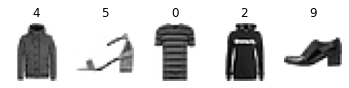

In [200]:
import matplotlib.pyplot as plt

for X, y in valid_set.take(2):
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

In [201]:
keras.backend.clear_session()

In [202]:
import numpy as np

class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

In [203]:
# standardization = Standardization(input_shape=[28, 28])
standardization = keras.layers.Normalization(input_shape=[28, 28])

sample_image_batches = train_set.take(420).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()), axis=0).astype(np.float32)
standardization.adapt(sample_images)

In [204]:
model = keras.models.Sequential([
    standardization,
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [205]:
import os
from datetime import datetime

logs = os.path.join(os.curdir, "my_logs", "run_" + datetime.now().strftime("%Y%m%d_%H%M%S"))

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=logs, histogram_freq=1, profile_batch=10)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10)

model.fit(train_set, epochs=100, validation_data=valid_set, callbacks=[tensorboard_cb, earlystopping_cb])

Epoch 1/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4435 - accuracy: 0.8417 - val_loss: 0.3685 - val_accuracy: 0.8674
Epoch 2/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3333 - accuracy: 0.8784 - val_loss: 0.3484 - val_accuracy: 0.8728
Epoch 3/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2948 - accuracy: 0.8918 - val_loss: 0.3558 - val_accuracy: 0.8710
Epoch 4/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2703 - accuracy: 0.9001 - val_loss: 0.3443 - val_accuracy: 0.8804
Epoch 5/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2522 - accuracy: 0.9079 - val_loss: 0.3607 - val_accuracy: 0.8694
Epoch 6/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2340 - accuracy: 0.9131 - val_loss: 0.3436 - val_accuracy: 0.8790
Epoch 7/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2198 - accuracy: 0.9189 - val_loss: 0.3505 - val_ac

In [206]:
%tensorboard

UsageError: Line magic function `%tensorboard` not found.


In [207]:
from pathlib import Path

DOWNLOAD_ROOT = "http://ai.stanford.edu/~amaas/data/sentiment/"
FILENAME = "aclImdb_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME, DOWNLOAD_ROOT + FILENAME, extract=True)
path = Path(filepath).parent / "aclImdb"
path

WindowsPath('C:/Users/ozing/.keras/datasets/aclImdb')

In [208]:
for name, subdirs, files in os.walk(path):
    indent = len(Path(name).parts) - len(path.parts)
    print("    " * indent + Path(name).parts[-1] + os.sep)
    for index, filename in enumerate(sorted(files)):
        if index == 3:
            print("    " * (indent + 1) + "...")
            break
        print("    " * (indent + 1) + filename)

aclImdb\
    README
    imdb.vocab
    imdbEr.txt
    test\
        labeledBow.feat
        urls_neg.txt
        urls_pos.txt
        neg\
            0_2.txt
            10000_4.txt
            10001_1.txt
            ...
        pos\
            0_10.txt
            10000_7.txt
            10001_9.txt
            ...
    train\
        labeledBow.feat
        unsupBow.feat
        urls_neg.txt
        ...
        neg\
            0_3.txt
            10000_4.txt
            10001_4.txt
            ...
        pos\
            0_9.txt
            10000_8.txt
            10001_10.txt
            ...
        unsup\
            0_0.txt
            10000_0.txt
            10001_0.txt
            ...


In [209]:
def review_paths(dirpath):
    return [str(path) for path in dirpath.glob("*.txt")]

train_pos = review_paths(path / "train" / "pos")
train_neg = review_paths(path / "train" / "neg")
test_valid_pos = review_paths(path / "test" / "pos")
test_valid_neg = review_paths(path / "test" / "neg")

len(train_pos), len(train_neg), len(test_valid_pos), len(test_valid_neg)

(12500, 12500, 12500, 12500)

In [210]:
np.random.shuffle(test_valid_pos)

test_pos = test_valid_pos[:5000]
test_neg = test_valid_neg[:5000]
valid_pos = test_valid_pos[5000:]
valid_neg = test_valid_neg[5000:]

In [211]:
# 데이터셋이 메모리에 적당할 때, 정확도 100%?
def imdb(filepath_pos, filepath_neg):
    reviews = []
    labels = []
    for filepaths, label in ((filepath_pos, 0), (filepath_neg, 1)):
        for filepath in filepaths:
            with open(filepath) as review_file:
                reviews.append(review_file.read())
            labels.append(label)
        return tf.data.Dataset.from_tensor_slices((tf.constant(reviews), tf.constant(labels)))

In [212]:
for X, y in imdb(train_pos, train_neg).take(1):
    print(X)
    print(y)

tf.Tensor(b'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)


In [213]:
%timeit -r1 for X, y in imdb(train_pos, train_neg).repeat(10): pass

12.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [214]:
# 데이터셋이 메모리에 적당하지 않을 때, 정확도:77%
def imdb_dataset(filepaths_positive, filepaths_negative, n_read_threads=5):
    dataset_neg = tf.data.TextLineDataset(filepaths_negative, num_parallel_reads=n_read_threads)
    dataset_neg = dataset_neg.map(lambda review: (review, 0))
    dataset_pos = tf.data.TextLineDataset(filepaths_positive, num_parallel_reads=n_read_threads)
    dataset_pos = dataset_pos.map(lambda review: (review, 1))
    return tf.data.Dataset.concatenate(dataset_pos, dataset_neg)

In [215]:
batch_size = 32
train_set = imdb_dataset(train_pos, train_neg).shuffle(25000).batch(batch_size).prefetch(1)
valid_set = imdb_dataset(valid_pos, valid_neg).batch(batch_size).prefetch(1)
test_set = imdb_dataset(test_pos, test_neg).batch(batch_size).prefetch(1)

In [231]:
def preprocess(X_batch, n_words=100):
    shape = tf.shape(X_batch) * tf.constant([1, 0]) + tf.constant([0, n_words])
    Z = tf.strings.substr(X_batch, 0, 300)
    Z = tf.strings.lower(Z)
    Z = tf.strings.regex_replace(Z, b"<br\\s*/?>", b" ")
    Z = tf.strings.regex_replace(Z, b"[^a-z]", b" ")
    Z = tf.strings.split(Z)
    return Z.to_tensor(shape=shape, default_value=b"<pad>")

In [217]:
X_example = tf.constant(["It's a great, great movie! I loved it.", "It was terrible, run away!!!"])
preprocess(X_example)

<tf.Tensor: shape=(2, 50), dtype=string, numpy=
array([[b'it', b's', b'a', b'great', b'great', b'movie', b'i', b'loved',
        b'it', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>'],
       [b'it', b'was', b'terrible', b'run', b'away', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'

In [218]:
from collections import Counter

def get_vocabulary(data_sample, max_size=1000):
    preprocessed_reviews = preprocess(data_sample).numpy()
    counter = Counter()
    for words in preprocessed_reviews:
        for word in words:
            if word != b"<pad>":
                counter[word] += 1
    return [b"<pad>"] + [word for word, count in counter.most_common(max_size)]

In [219]:
get_vocabulary(X_example)

[b'<pad>',
 b'it',
 b'great',
 b's',
 b'a',
 b'movie',
 b'i',
 b'loved',
 b'was',
 b'terrible',
 b'run',
 b'away']

In [220]:
keras.backend.clear_session()

In [221]:
class TextVectorization(keras.layers.Layer):
    def __init__(self, max_vocabulary_size=1000, n_oov_buckets=100, dtype=tf.string, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.max_vocabulary_size = max_vocabulary_size
        self.n_oov_buckets = n_oov_buckets

    def adapt(self, data_sample):
        self.vocab = get_vocabulary(data_sample, self.max_vocabulary_size)
        words = tf.constant(self.vocab)
        word_ids = tf.range(len(self.vocab), dtype=tf.int64)
        vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
        self.table = tf.lookup.StaticVocabularyTable(vocab_init, self.n_oov_buckets)
        
    def call(self, inputs):
        preprocessed_inputs = preprocess(inputs)
        return self.table.lookup(preprocessed_inputs)

In [222]:
text_vectorization = TextVectorization()
text_vectorization.adapt(X_example)
text_vectorization(X_example)

<tf.Tensor: shape=(2, 50), dtype=int64, numpy=
array([[ 1,  3,  4,  2,  2,  5,  6,  7,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 1,  8,  9, 10, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]], dtype=int64)>

In [287]:
max_vocabulary_size = 1000
n_oov_buckets = 100
sample_review_batches = train_set.map(lambda review, label: review)
sample_reviews = np.concatenate(list(sample_review_batches.as_numpy_iterator()), axis=0)
text_vectorization = TextVectorization(max_vocabulary_size, n_oov_buckets, input_shape=[])
text_vectorization.adapt(sample_reviews)
text_vectorization(X_example)

<tf.Tensor: shape=(2, 100), dtype=int64, numpy=
array([[  7,  14,   2,  64,  64,  12,   5, 265,   7,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  7,  13, 271, 526, 336,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,

In [288]:
text_vectorization.vocab[:10]

[b'<pad>', b'the', b'a', b'and', b'of', b'i', b'to', b'it', b'is', b'this']

In [300]:
text_vectorization = keras.layers.TextVectorization(max_tokens=max_vocabulary_size)
text_vectorization.adapt(sample_reviews)
text_vectorization(X_example)

<tf.Tensor: shape=(2, 8), dtype=int64, numpy=
array([[ 30,   4,  85,  85,  18,  10, 434,   9],
       [  9,  14, 384, 530, 242,   0,   0,   0]], dtype=int64)>

In [301]:
simple_example = tf.constant([[1,3,1,0,0], [2,2,0,0,0]])
tf.reduce_sum(tf.one_hot(simple_example, 4), axis=1)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[2., 2., 0., 1.],
       [3., 0., 2., 0.]], dtype=float32)>

In [302]:
class BagOfWords(keras.layers.Layer):
    def __init__(self, n_tokens, dtype=tf.int32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.n_tokens = n_tokens
    def call(self, inputs):
        one_hot = tf.one_hot(inputs, self.n_tokens)
        return tf.reduce_sum(one_hot, axis=1)[:, 1:]

In [303]:
bag_of_words = BagOfWords(n_tokens=4)
bag_of_words(simple_example)
# index 0 제외 1,2,3 순서 (1 2개, 3 1개)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[2., 0., 1.],
       [0., 2., 0.]], dtype=float32)>

In [304]:
n_tokens = max_vocabulary_size + n_oov_buckets + 1
bag_of_words = BagOfWords(n_tokens)

In [305]:
model = keras.models.Sequential([
    text_vectorization,
    bag_of_words,
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
])

model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])

model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
782/782 [==============================] - 35s 42ms/step - loss: 0.4111 - accuracy: 0.8250 - val_loss: 0.3433 - val_accuracy: 0.8567
Epoch 2/5
782/782 [==============================] - 34s 42ms/step - loss: 0.3399 - accuracy: 0.8579 - val_loss: 0.4340 - val_accuracy: 0.8239
Epoch 3/5
782/782 [==============================] - 34s 42ms/step - loss: 0.3076 - accuracy: 0.8713 - val_loss: 0.3627 - val_accuracy: 0.8439
Epoch 4/5
782/782 [==============================] - 34s 42ms/step - loss: 0.2673 - accuracy: 0.8896 - val_loss: 0.3688 - val_accuracy: 0.8391
Epoch 5/5
782/782 [==============================] - 33s 42ms/step - loss: 0.2223 - accuracy: 0.9101 - val_loss: 0.3553 - val_accuracy: 0.8522


In [306]:
model.evaluate(test_set)

313/313 [==============================] - 8s 25ms/step - loss: 0.3469 - accuracy: 0.8589


[0.34688103199005127, 0.8589000105857849]

In [307]:
def compute_mean_embedding(inputs):
    not_pad = tf.math.count_nonzero(inputs, axis=-1)
    n_words = tf.math.count_nonzero(not_pad, axis=-1, keepdims=True)
    sqrt_n_words = tf.math.sqrt(tf.cast(n_words, tf.float32))
    return tf.reduce_sum(inputs, axis=1) / sqrt_n_words

In [308]:
another_example = tf.constant([[[3., 2., 1.], [4., 5., 0.], [0., 0., 0.]], [[1., 2., 0.], [3., 0., 0.], [0., 0., 0.]]])
compute_mean_embedding(another_example)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[4.9497476 , 4.9497476 , 0.70710677],
       [2.828427  , 1.4142135 , 0.        ]], dtype=float32)>

In [309]:
embedding_size = 20

model = keras.models.Sequential([
    text_vectorization,
    keras.layers.Embedding(input_dim=n_tokens, output_dim=embedding_size, mask_zero=True),
    keras.layers.Lambda(compute_mean_embedding),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
])

model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])

model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
782/782 [==============================] - 10s 11ms/step - loss: 0.4815 - accuracy: 0.7633 - val_loss: 0.4071 - val_accuracy: 0.8068
Epoch 2/5
782/782 [==============================] - 9s 11ms/step - loss: 0.3453 - accuracy: 0.8505 - val_loss: 0.3447 - val_accuracy: 0.8495
Epoch 3/5
782/782 [==============================] - 9s 11ms/step - loss: 0.3239 - accuracy: 0.8620 - val_loss: 0.3232 - val_accuracy: 0.8585
Epoch 4/5
782/782 [==============================] - 9s 11ms/step - loss: 0.3140 - accuracy: 0.8657 - val_loss: 0.3225 - val_accuracy: 0.8589
Epoch 5/5
782/782 [==============================] - 9s 11ms/step - loss: 0.3089 - accuracy: 0.8668 - val_loss: 0.3218 - val_accuracy: 0.8601


In [310]:
model.evaluate(test_set)

313/313 [==============================] - 2s 6ms/step - loss: 0.3072 - accuracy: 0.8663


[0.30724701285362244, 0.8662999868392944]

In [312]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="imdb_reviews")
train_set, test_set = datasets["train"], datasets["test"]

In [313]:
for example in train_set.take(1):
    print(example["text"])
    print(example["label"])

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
